In [1]:
from pytorch_lightning import seed_everything
# set seed
seed = 7
seed_everything =(seed)
import pytorch_lightning as pl
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import json

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from pytorch_lightning.loggers import TensorBoardLogger

In [2]:
class Resent(pl.LightningModule):

    def __init__(self,batch_size):

        super(Resent, self).__init__()
        
        self.batch_size = batch_size
#         self.save_hyperparameters()


        ########## define the model ########## 
        net = torchvision.models.resnet50(pretrained=True)
        model_weight_path = "../input/resnet50/resnet50-19c8e357.pth"
        assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)
        net.load_state_dict(torch.load(model_weight_path))
        num_features = net.fc.in_features

        model = list(net.children())[:-1]  
        self.backbone = torch.nn.Sequential(*model)  # [bs, 512, 1, 1]
        self.final = torch.nn.Sequential(
            torch.nn.Linear(num_features, 1024),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(1024, 10),
            torch.nn.Softmax(dim=1))


    def forward(self, x):
        x = self.backbone(x)
        x = x.reshape(x.size(0), -1)
        x = self.final(x)

        return x


    def configure_optimizers(self):
        optimizer = torch.optim.SGD([
            {'params': self.backbone.parameters()},
            {'params': self.final.parameters(), 'lr': 1e-2}
        ], lr=1e-3, momentum=0.9)

        exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        return [optimizer], [exp_lr_scheduler]

        #         return torch.optim.Adam(self.parameters(), lr=0.001)


    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = torch.nn.functional.cross_entropy(y_hat, y)
        _, preds = torch.max(y_hat, dim=1)
        acc = torch.sum(preds == y.data) / (y.shape[0] * 1.0)

        self.log('train_loss', loss)
        self.log('train_acc', acc)

        return {'loss': loss, 'train_acc': acc}
    
    
    def evaluate(self, batch, stage=None):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        _, preds = torch.max(y_hat, dim=1)
        acc = torch.sum(preds == y.data) / (y.shape[0] * 1.0)

        if stage:
            self.log(f'{stage}_loss', loss, prog_bar=True)
            self.log(f'{stage}_acc', acc, prog_bar=True)


    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, 'val')


    def test_step(self, batch, batch_idx):
        self.evaluate(batch, 'test')


    def train_dataloader(self):
        transform = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        train_set = torchvision.datasets.ImageFolder(root='../input/cifar10-pngs-in-folders/cifar10/train', transform=transform)
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=150, shuffle=True,
                                                   num_workers=int(os.cpu_count() / 2))
        cifar_list = train_set.class_to_idx  # 返回其类别索引
        cla_dict = dict(
            (val, key) for key, val in cifar_list.items())  
        json_str = json.dumps(cla_dict, indent=10)
        with open('class_indices.json', "w") as json_file:
            json_file.write(json_str)

        return train_loader


    def val_dataloader(self):
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        val_set = torchvision.datasets.ImageFolder(root='../input/cifar10-pngs-in-folders/cifar10/test', transform=transform)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=150, shuffle=True,
                                                 num_workers=int(os.cpu_count() / 2))

        return val_loader


    def test_dataloader(self):
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        test_set = torchvision.datasets.ImageFolder(root='../input/cifar10-pngs-in-folders/cifar10/test', transform=transform)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=150, shuffle=True,
                                                  num_workers=int(os.cpu_count() / 2))

        return test_loader


In [ ]:
from pytorch_lightning.callbacks import LearningRateMonitor
def main():
    model = Resent(batch_size=150)
    trainer = pl.Trainer(
#         accelerator='dp',
        gpus=1,
        auto_select_gpus=True,
#         进度条长度
        progress_bar_refresh_rate=1,
        max_epochs=25,
#         自动获取Batch Size
        auto_scale_batch_size=True,
#         自动获取初始学习率
#         auto_lr_find=True,
#         展示网络信息
        weights_summary='top',
#         每隔四分之一个epoch做一次validation
        val_check_interval=0.5,
#        (代码测试) Trainer会为训练验证测试分别跑一个batch，从而找到潜在的Bugs。它不会产生logs和checkpoints
#         fast_dev_run=True,
        
        logger=TensorBoardLogger('lightning_logs/', name='Resnet50'),
        callbacks=[LearningRateMonitor(logging_interval='step')],
    )

    trainer.fit(model)
if __name__ == '__main__':
    main()

**恢复训练**

In [4]:
RESUME = True

if RESUME:
    model = Resent(batch_size=150)
    path = '../input/cifar-10-weights/epoch0-step166.ckpt'
    
    trainer = pl.Trainer(gpus=1, 
                max_epochs=3,             
                resume_from_checkpoint = path)
    trainer.fit(model)
#     trainer.save_checkpoint("CIFAR.ckpt")

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

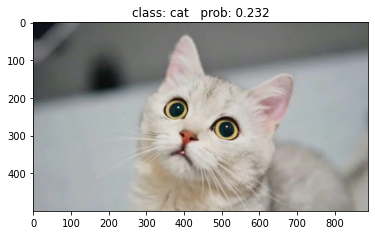

In [5]:
import os
import json
import torch
import torchvision.models
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt


def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    data_transform = transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    # load image
    img_path = "../input/catdog/cat.jpg"
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path)

    plt.imshow(img)
    # [N, C, H, W]
    img = data_transform(img)
    # expand batch dimension
    img = torch.unsqueeze(img, dim=0)

    # read class_indict
    json_path = '../input/type-json/class_indices.json'
    assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

    json_file = open(json_path, "r")
    class_indict = json.load(json_file)

    # create model
    model = Resent(batch_size=150).to(device)

    # load model weights
#     weights_path = "../../../weights/resNet34.pth"
#     assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
#     model.load_state_dict(torch.load(weights_path))
    path = '../input/cifar-10-weights/CIFAR_10_weights.ckpt'
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['state_dict'])

    model.eval()
    with torch.no_grad():
        # predict class
        output = torch.squeeze(model(img.to(device))[0]).cpu()
        predict = torch.softmax(output, dim=0)
        predict_cla = torch.argmax(predict).numpy()

    print_res = "class: {}   prob: {:.3f}".format(class_indict[str(predict_cla)],
                                                  predict[predict_cla].numpy())
    plt.title(print_res)
    plt.show()


if __name__ == '__main__':
    main()
